In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import seaborn as sns

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data_dir = "../data/processed"
image_dir = "../images"

In [3]:
df_cmpds_original = pd.read_pickle(os.path.join(data_dir, "BBBC021_original_compounds_fps.pickle"))

In [4]:
df_cmpds_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 3 to 112
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Image_Metadata_Compound  35 non-null     object
 1   Image_Metadata_MoA       35 non-null     object
 2   Image_Metadata_SMILES    35 non-null     object
 3   mol                      35 non-null     object
 4   morgan_fp                35 non-null     object
dtypes: object(5)
memory usage: 1.6+ KB


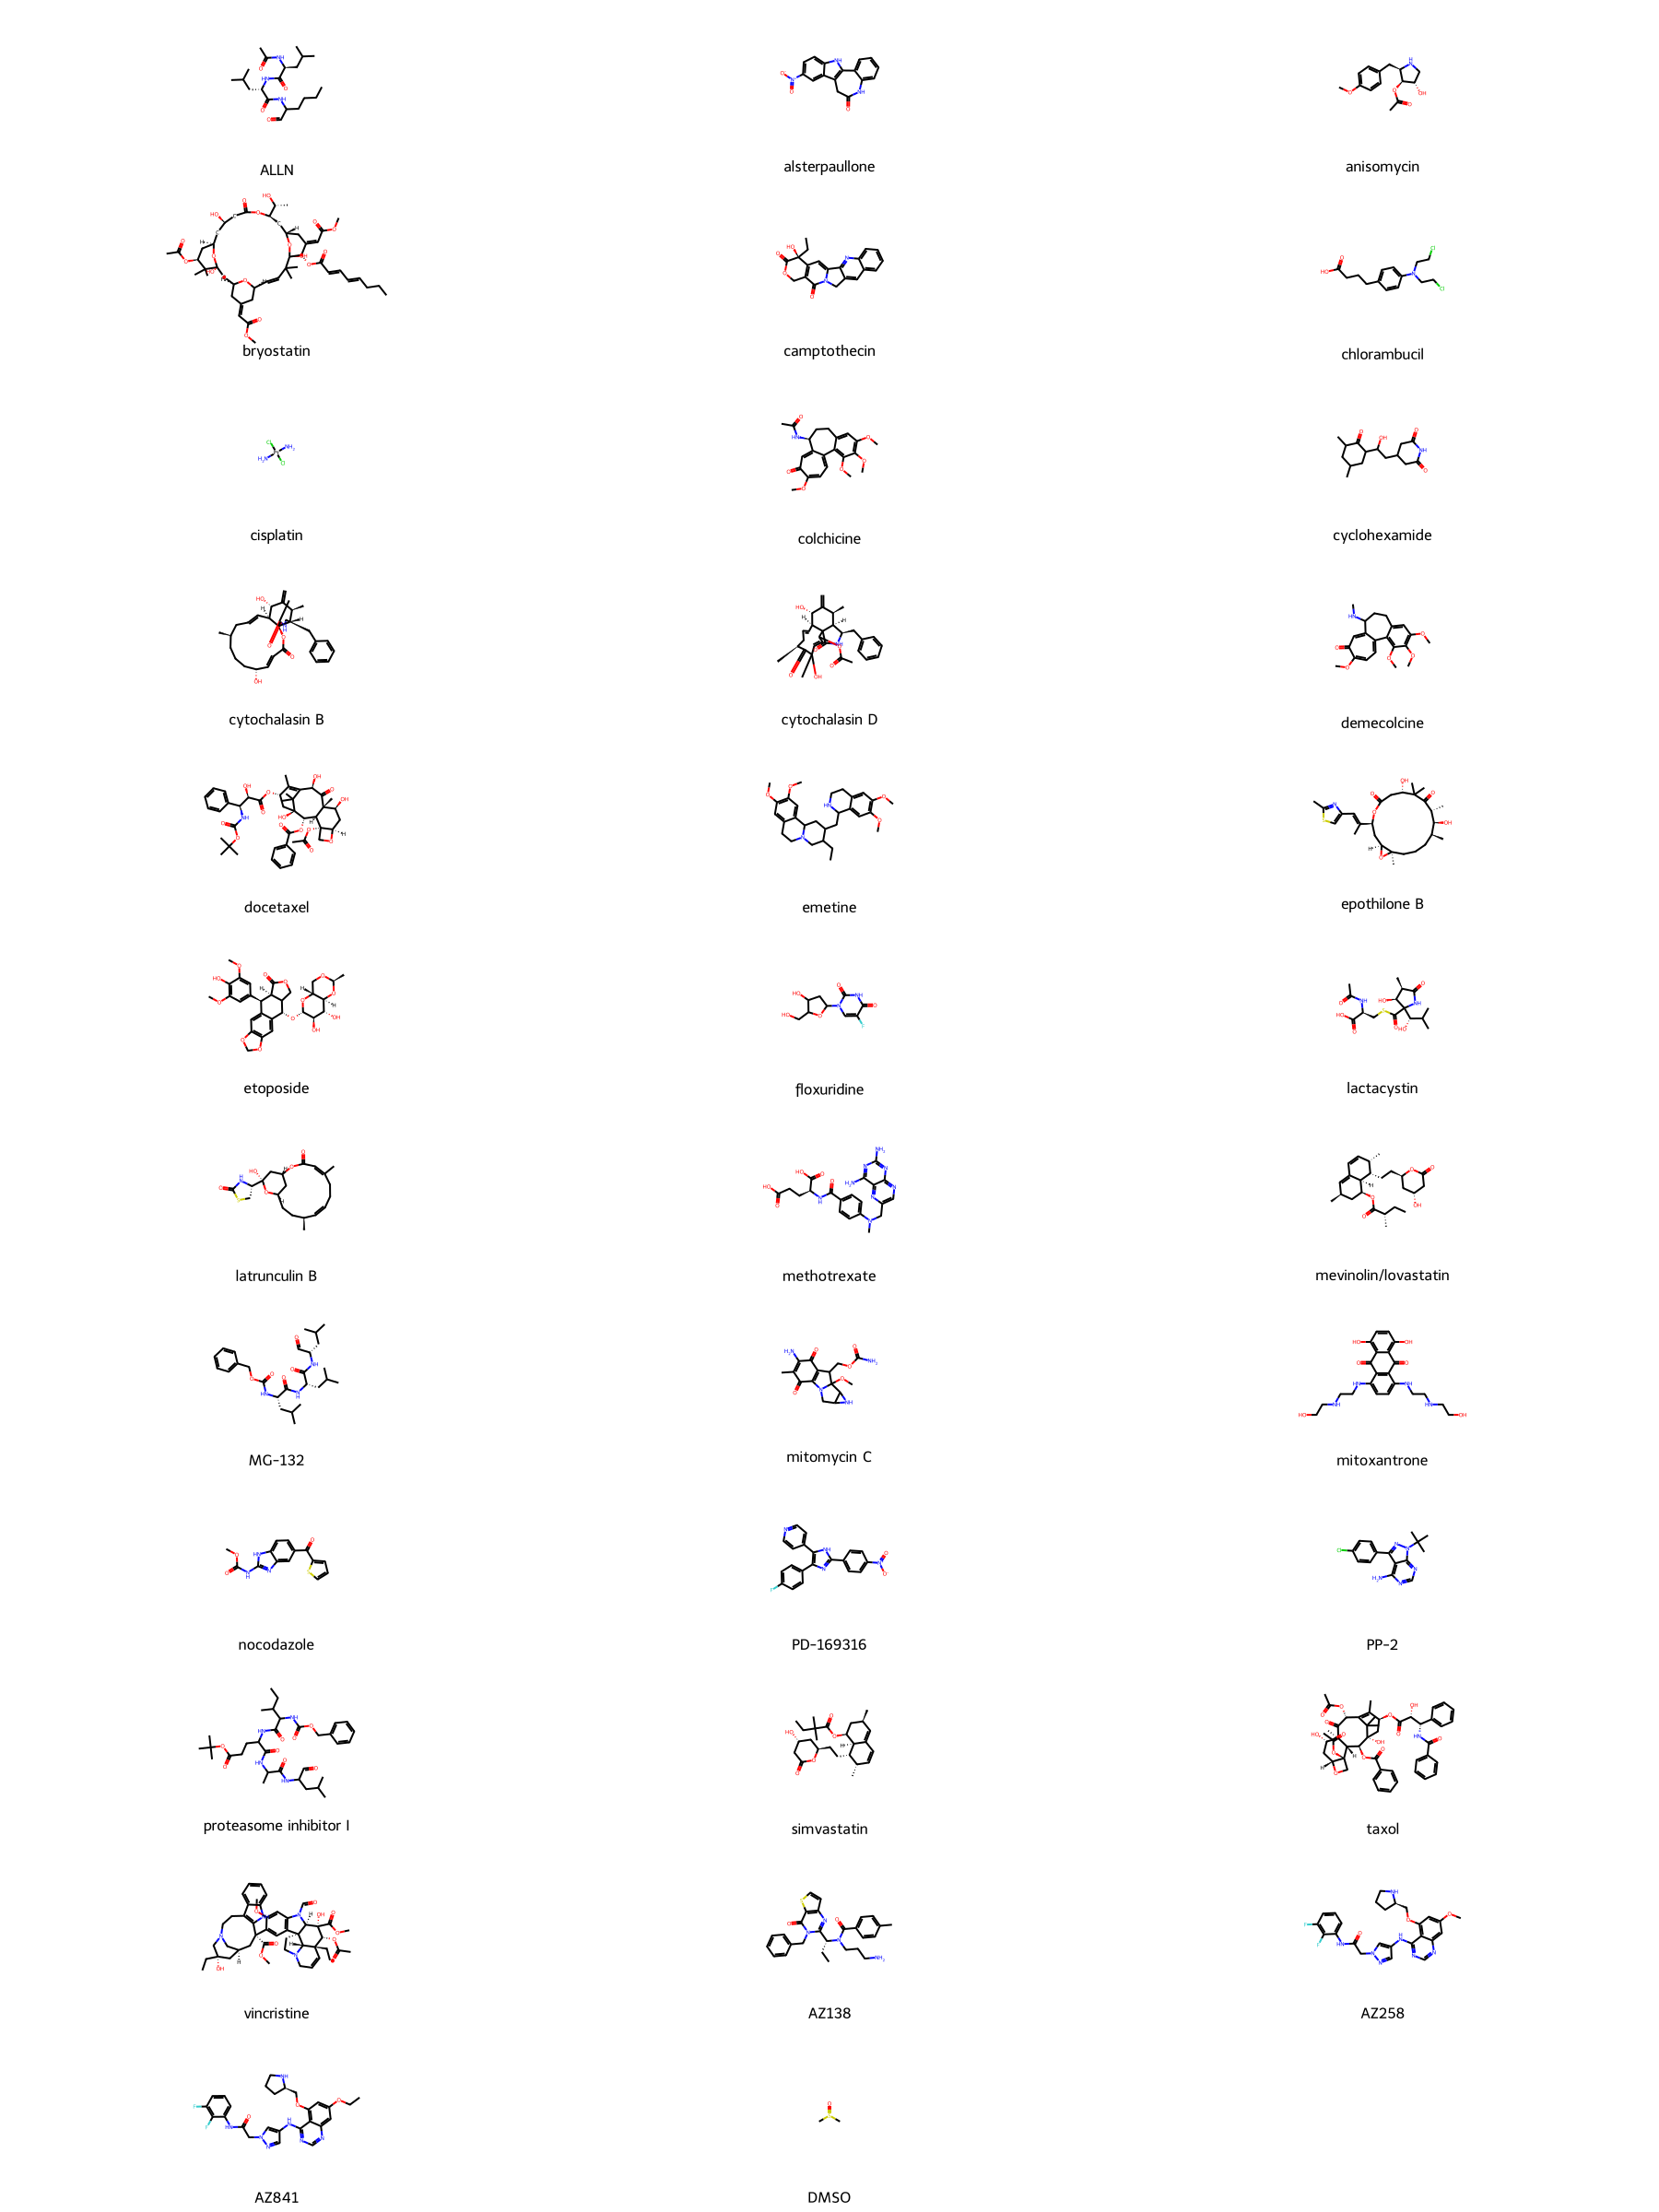

In [5]:
Draw.MolsToGridImage(
    df_cmpds_original["mol"].to_list(),
    molsPerRow=3,
    subImgSize=(600, 200),
    legends=df_cmpds_original["Image_Metadata_Compound"].to_list(),
)

In [6]:
df_cmpds_original = df_cmpds_original.sort_values(["Image_Metadata_MoA", "Image_Metadata_Compound"])

In [7]:
compounds = df_cmpds_original["Image_Metadata_Compound"].to_numpy()
fingerprints = df_cmpds_original["morgan_fp"].to_numpy()
moas = df_cmpds_original["Image_Metadata_MoA"].unique()

In [8]:
def create_fp_sim_matix(fps):
    sim_matrix = np.zeros((len(fps), len(fps)))

    for i in range(len(fps)):
        for j in range(len(fps)):
            sim_matrix[i][j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return sim_matrix

In [9]:
similarity_matrix = create_fp_sim_matix(fingerprints)
distance_matrix = 1 - similarity_matrix

In [10]:
def get_bounderies(df):
    moa_list = df["Image_Metadata_MoA"].to_list()
    m0 = moa_list[0]
    bounderies = list()
    for i, m in enumerate(df["Image_Metadata_MoA"].to_list()):
        if m != m0:
            bounderies.append(i)
            m0 = m
    return bounderies

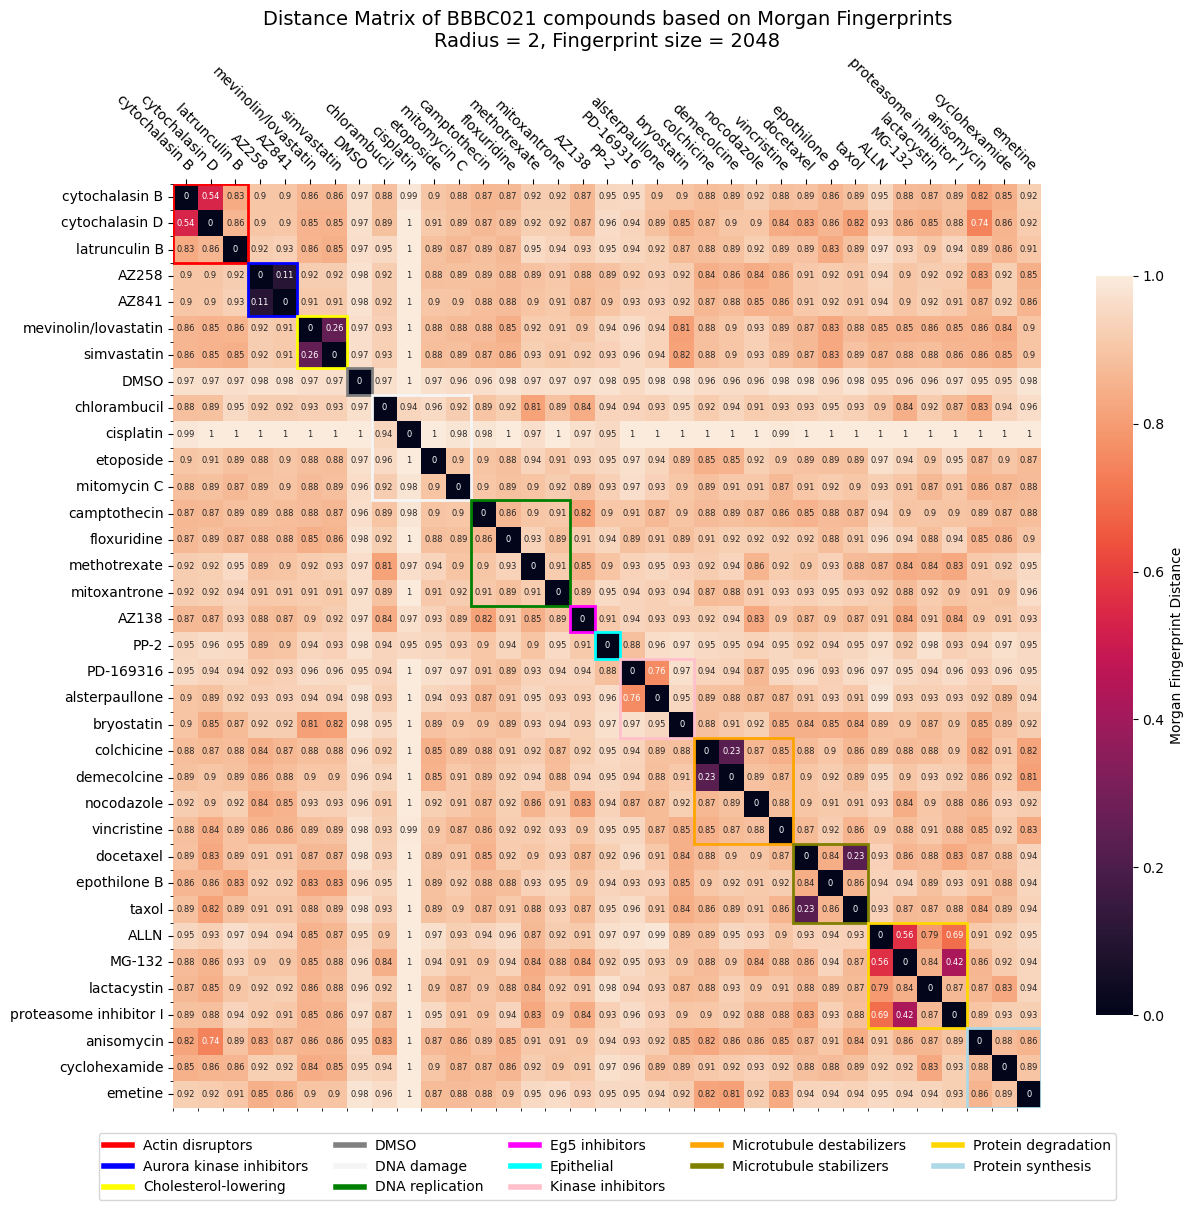

In [11]:
plot_title = "Distance Matrix of BBBC021 compounds based on Morgan Fingerprints\nRadius = 2, Fingerprint size = 2048"

fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(distance_matrix, 
            annot=True, 
            annot_kws={"fontsize":6, "ha": "center"}, 
            fmt=".2g", 
            cbar_kws={"label": "Morgan Fingerprint Distance", "shrink": 0.8}, 
            ax=ax)
ax.set_yticks(range(len(compounds)), minor=True)
ax.set_yticklabels(compounds)
ax.set_xticks(range(len(compounds)), minor=True)
ax.set_xticklabels(compounds)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(plot_title, fontsize=14)

ax.add_patch(patches.Rectangle((0, 0), 3.0, 3.0, edgecolor="red", lw=2, fill=False))
ax.add_patch(patches.Rectangle((3, 3), 2.0, 2.0, edgecolor="blue", lw=2, fill=False))
ax.add_patch(patches.Rectangle((5, 5), 2.0, 2.0, edgecolor="yellow", lw=2, fill=False))
ax.add_patch(patches.Rectangle((7, 7), 1.0, 1.0, edgecolor="grey", lw=2, fill=False))
ax.add_patch(patches.Rectangle((8, 8), 4.0, 4.0, edgecolor="whitesmoke", lw=2, fill=False))
ax.add_patch(patches.Rectangle((12, 12), 4.0, 4.0, edgecolor="green", lw=2, fill=False))
ax.add_patch(patches.Rectangle((16, 16), 1.0, 1.0, edgecolor="magenta", lw=2, fill=False))
ax.add_patch(patches.Rectangle((17, 17), 1.0, 1.0, edgecolor="cyan", lw=2, fill=False))
ax.add_patch(patches.Rectangle((18, 18), 3.0, 3.0, edgecolor="pink", lw=2, fill=False))
ax.add_patch(patches.Rectangle((21, 21), 4.0, 4.0, edgecolor="orange", lw=2, fill=False))
ax.add_patch(patches.Rectangle((25, 25), 3.0, 3.0, edgecolor="olive", lw=2, fill=False))
ax.add_patch(patches.Rectangle((28, 28), 4.0, 4.0, edgecolor="gold", lw=2, fill=False))
ax.add_patch(patches.Rectangle((32, 32), 3.0, 3.0, edgecolor="lightblue", lw=2, fill=False))

custom_legend = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="yellow", lw=4),
                Line2D([0], [0], color="grey", lw=4),
                Line2D([0], [0], color="whitesmoke", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="magenta", lw=4),
                Line2D([0], [0], color="cyan", lw=4),
                Line2D([0], [0], color="pink", lw=4),
                Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="olive", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="lightblue", lw=4)]

ax.legend(custom_legend, moas, loc='upper center', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=False, ncol=5)

plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

plt.show()

In [12]:
fig.savefig(os.path.join(image_dir, "FP_distance_matrix.png"), bbox_inches="tight")

In [13]:
def generate_moa_dist_matrix(df, moa, ax):
    cmpd_list = df[df["Image_Metadata_MoA"] == moa]["Image_Metadata_Compound"].to_numpy()
    cmpd_idx = [i for i, c in enumerate(compounds) if c in cmpd_list]
    moa_dist = np.zeros((len(cmpd_idx), len(cmpd_idx)))
    for k in range(len(cmpd_idx)):
        for l in range(len(cmpd_idx)):
            moa_dist[k][l] = distance_matrix[cmpd_idx[k]][cmpd_idx[l]]

    sns.heatmap(moa_dist, 
                annot=True, 
                annot_kws={"fontsize":8, "ha": "center"}, 
                fmt=".4g", 
                cbar_kws={"label": "Morgan Fingerprint Distance", "shrink": 0.6},
                vmin=0.0,
                vmax=1.0,
                square=True,
                ax=ax)
    ax.set_yticks(range(len(cmpd_idx)), minor=True)
    ax.set_yticklabels(cmpd_list)
    ax.set_xticks(range(len(cmpd_idx)), minor=True)
    ax.set_xticklabels(cmpd_list)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.set_title(f"Distance Matrix MoA - {moa}", fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

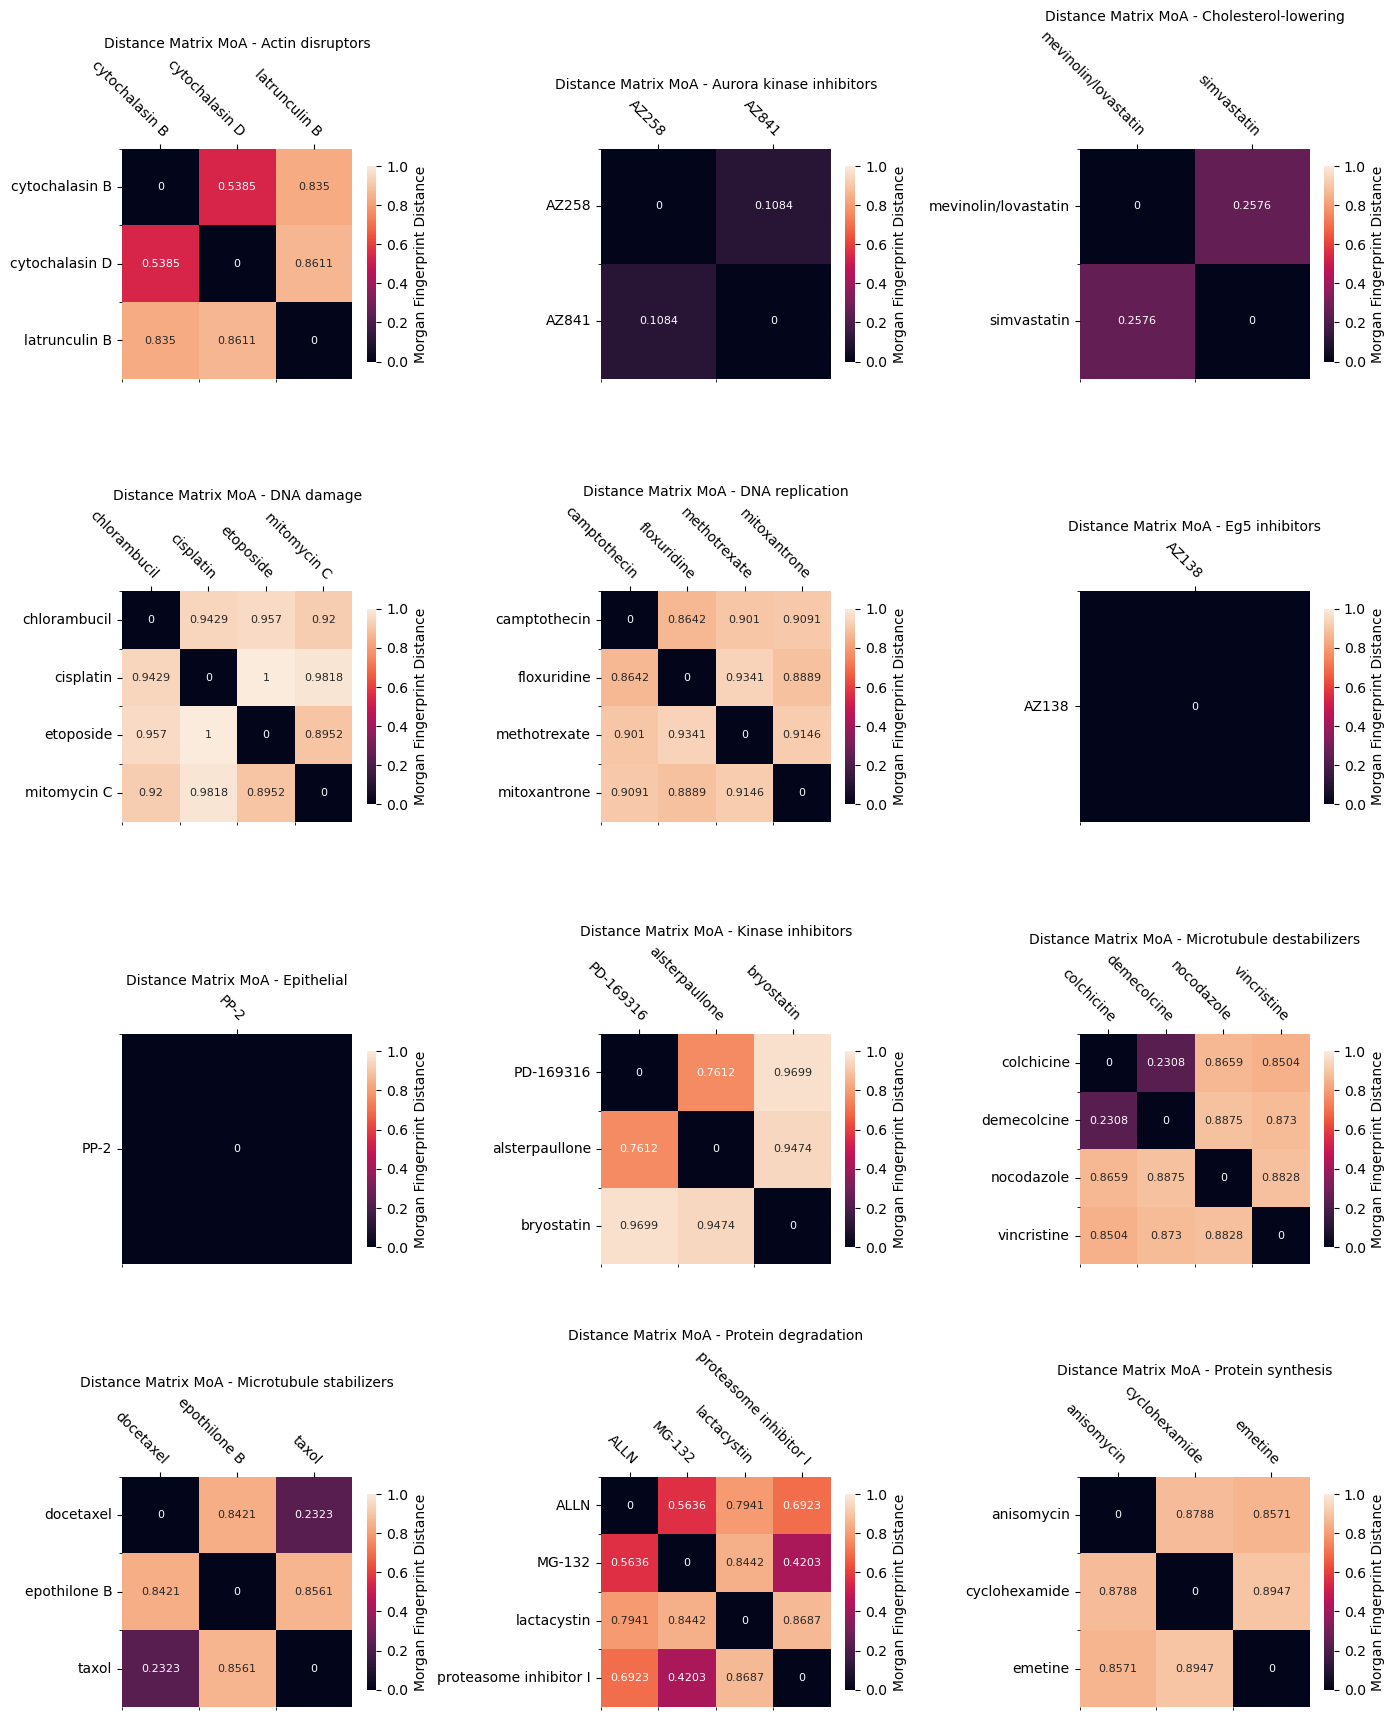

In [14]:
moas_non_dmso = [m for m in moas if m != "DMSO"]
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,18))
for i, ax in enumerate(axes.flat):
    generate_moa_dist_matrix(df_cmpds_original, moas_non_dmso[i], ax)
plt.tight_layout()
plt.show()

In [15]:
fig.savefig(os.path.join(image_dir, "FP_distance_matrix_by_MoA.png"))

---

In [16]:
random_seed = 42

X = np.stack(df_cmpds_original["morgan_fp"])

In [17]:
cluster_range = range(2,35)
silhouette_score_list = list()
cluster_label_dict = dict()

for num_clust in cluster_range:
    km_clust = KMeans(n_clusters=num_clust, random_state=random_seed, n_init='auto')
    cluster_labels = km_clust.fit_predict(X)
    cluster_label_dict[num_clust] = cluster_labels
    score = silhouette_score(X, cluster_labels)
    silhouette_score_list.append([num_clust, score])

df_cluser_score = pd.DataFrame(silhouette_score_list, columns=["Num Clusters", "Silhouette Score"])

In [18]:
df_cluser_score.loc[df_cluser_score["Silhouette Score"].idxmax(), :]

Num Clusters        25.000000
Silhouette Score     0.160188
Name: 23, dtype: float64

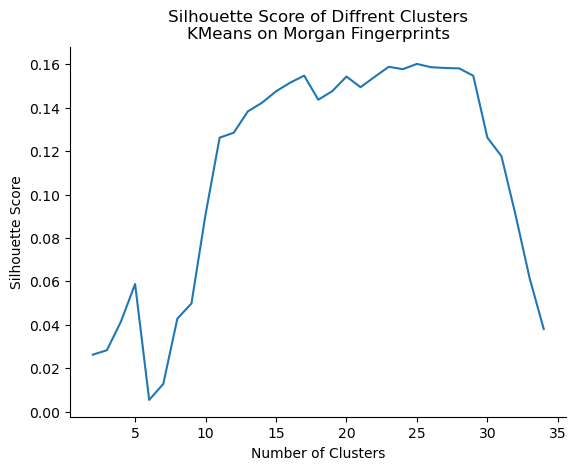

In [19]:
fig, ax = plt.subplots()
sns.lineplot(data=df_cluser_score, x="Num Clusters", y="Silhouette Score", ax=ax)
ax.set_ylabel("Silhouette Score")
ax.set_xlabel("Number of Clusters")
ax.set_title("Silhouette Score of Diffrent Clusters\nKMeans on Morgan Fingerprints")
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [20]:
fig.savefig(os.path.join(image_dir, "FP_KMeans_silhoutte_score.png"))

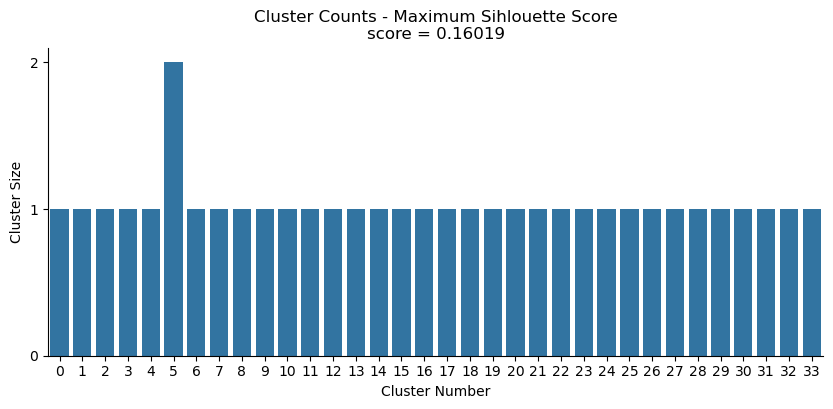

In [21]:
num_cluster = int(df_cluser_score.loc[df_cluser_score["Silhouette Score"].idxmax(), :]["Num Clusters"])
clusters = cluster_label_dict[num_clust]

unique, counts = np.unique(clusters, return_counts=True)
df_cluster_counts = pd.DataFrame.from_records(data=list(zip(unique, counts)), columns=["Cluster", "Count"])

fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=df_cluster_counts, x="Cluster", y="Count", ax=ax)
ax.set_yticks(range(3), labels=[0, 1, 2])
ax.set_ylabel("Cluster Size")
ax.set_xlabel("Cluster Number")
ax.set_title(f"Cluster Counts - Maximum Sihlouette Score\nscore = {df_cluser_score.loc[df_cluser_score['Silhouette Score'].idxmax(), :]['Silhouette Score']:.5f}")
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [22]:
fig.savefig(os.path.join(image_dir, "FP_KMeans_cluster_counts.png"))

In [23]:
cluster_max_count = np.where(clusters == 5)[0]
df_cluster_max = df_cmpds_original.iloc[cluster_max_count, :]

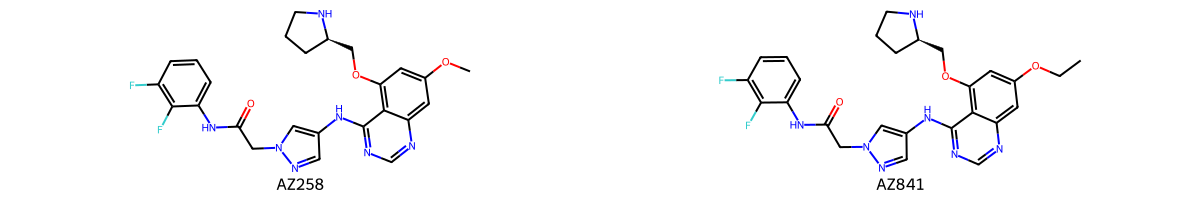

In [24]:
Draw.MolsToGridImage(
    df_cluster_max["mol"].to_list(),
    molsPerRow=2,
    subImgSize=(600, 200),
    legends=df_cluster_max["Image_Metadata_Compound"].to_list(),
)